In [82]:
import datetime
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [83]:
train = pd.read_csv("data/train_clean.csv", index_col="id", parse_dates=["timestamp"])
test = pd.read_csv("data/test_clean.csv", index_col="id", parse_dates=["timestamp"])
macro = pd.read_csv("data/macro.csv", parse_dates=["timestamp"])

In [84]:
y_train = train["price_doc"]
x_train = train.drop(["timestamp", "price_doc"], axis=1)

In [85]:
# transform non-numerical variables
for c in x_train.columns:
    if x_train[c].dtype == "object":
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[c].values)) 
        x_train[c] = lbl.transform(list(x_train[c].values))

y_train = y_train.astype(np.float32)
x_train = x_train.astype(np.float32)

In [86]:
x_test = test.drop(["timestamp"], axis=1)

In [87]:
# transform non-numerical variables
for c in x_test.columns:
    if x_test[c].dtype == "object":
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[c].values)) 
        x_test[c] = lbl.transform(list(x_test[c].values))
        
x_test = x_test.astype(np.float32)

In [88]:
xgb_params = {
    "eta": 0.05,
    "max_depth": 5,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "objective": "reg:linear",
    "eval_metric": "rmse",
    "silent": 1,
    "seed":42
}

In [89]:
dtrain = xgb.DMatrix(x_train, y_train)

In [90]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                   verbose_eval=50, show_stdv=False)

[0]	train-rmse:8.10853e+06	test-rmse:8.11491e+06
[50]	train-rmse:2.45817e+06	test-rmse:2.82064e+06
[100]	train-rmse:2.15282e+06	test-rmse:2.66133e+06
[150]	train-rmse:2.03976e+06	test-rmse:2.62748e+06
[200]	train-rmse:1.96516e+06	test-rmse:2.61267e+06
[250]	train-rmse:1.89868e+06	test-rmse:2.60266e+06
[300]	train-rmse:1.84018e+06	test-rmse:2.59635e+06


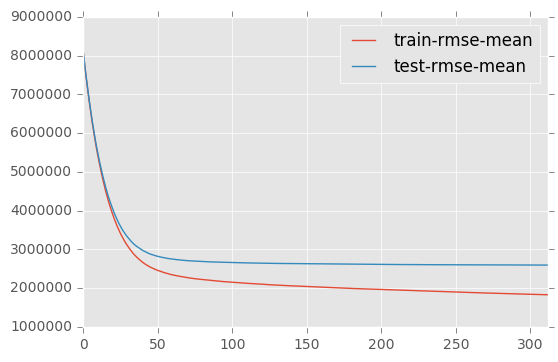

In [91]:
cv_output[["train-rmse-mean", "test-rmse-mean"]].plot()
pass

In [92]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

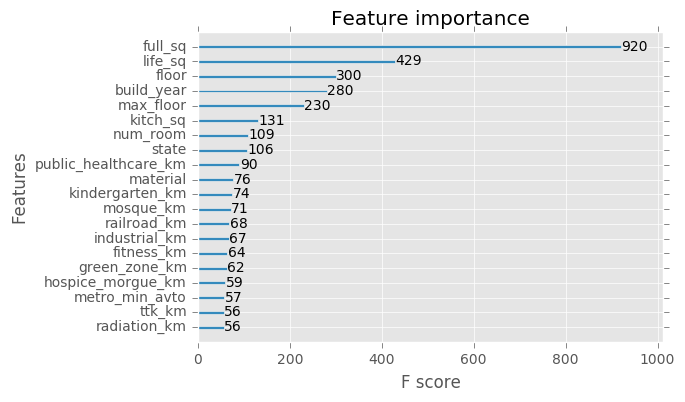

In [94]:
xgb.plot_importance(model, max_num_features=20)

In [95]:
pred = model.predict(dtrain)

In [96]:
error = np.mean(abs(pred - y_train)) / len(y_train)

In [97]:
n = 1 / len(y_train)
rmsle = np.sqrt(1/n * np.sum(np.power(np.log(pred + 1) - np.log(y_train.values + 1), 2)))

/Users/datitran/anaconda/envs/kaggle/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


In [98]:
print("RMSLE: {rmsle}, Error: {error}".format(rmsle=rmsle, error=error))

RMSLE: nan, Error: 42.00635255833276


In [99]:
dtest = xgb.DMatrix(x_test)

In [100]:
y_predict = model.predict(dtest)

In [101]:
output = pd.DataFrame({"id": x_test.index, "price_doc": y_predict})

In [102]:
output.to_csv("submissions_clean_{}.csv".format(datetime.datetime.today()), index=False)